### Bagging 
#### gini

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs

iris = load_breast_cancer()
X = iris.data
y = iris.target

# X, y = make_blobs(n_samples=3000, centers=4,random_state=40, cluster_std=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, shuffle=True, random_state=42)

print('======= Train =======')
print(X_train.shape,y_train.shape)
print('======= Test =======')
print(X_test.shape,y_test.shape)

======= Train =======
(398, 30) (398,)
======= Test =======
(171, 30) (171,)


In [13]:
import random, math
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier
import random
from scipy import stats
from sklearn.metrics import classification_report,accuracy_score

class Bagging:
    def __init__(self,B,bootstrap_ratio,with_no_replacement = True):
        self.B = B
        self.bootstrap_ratio = bootstrap_ratio #100% replacement
        self.with_no_replacement = with_no_replacement
        ##### criterion: 'gini','entropy'
        self.tree_params = {'max_depth': 2, 'criterion':'gini', 'min_samples_split': 5}
        self.models = [DecisionTreeClassifier(**self.tree_params) for _ in range(B)] # 5 different decision trees
    
    def fit(self,X,y):
        m, n = X.shape
        # print(m,n)

        #sample size for each tree
        sample_size = int(self.bootstrap_ratio * len(X))
        print('sample_size',sample_size)

        xsamples = np.zeros((self.B, sample_size, n)) 
        ysamples = np.zeros((self.B, sample_size))
        '''
        xsamples = (#trees, sample_size, features)
        ysamples = (#trees, sample_size)
        '''
        
        xsamples_oob = [] # list because length is not known
        ysamples_oob = []
        # print(ysamples.shape)

#subsamples for each model
        for i in range(self.B):
            ##sampling with replacement; i.e., sample can occur more than once
            # for the same predictor
            oob_idx = []
            idxes = []
            for j in range(sample_size):
                idx = random.randrange(m)   #<----with replacement #change so no repetition
                if self.with_no_replacement:
                    while idx in idxes:
                        idx = random.randrange(m) 
                # print(idx)
                # print('X_train',X_train[idx])
                idxes.append(idx)
                oob_idx.append(idx)
                xsamples[i, j, :] = X[idx]
                # print('xsamples',xsamples)
                ysamples[i, j] = y[idx]
            mask = np.zeros((m),dtype = bool)
            mask[oob_idx] = True
            xsamples_oob.append(X[~mask])
            ysamples_oob.append(y[~mask])

                # print('xsamples',xsamples.shape)
                # print('ysamples',ysamples.shape)
                # print('xsamples',xsamples[2,:])

            #fitting each estimator
        oob_score = 0
        for i, model in enumerate(self.models):
#             print(i)
            _X = xsamples[i, :]
#             print('_X',_X.shape)
            _y = ysamples[i, :]
#             print('_y',_y.shape)
            model.fit(_X, _y)

            #calculating oob score
            _X_test = np.asarray(xsamples_oob[i])
            _y_test = np.asarray(ysamples_oob[i])
            yhat = model.predict(_X_test)
            oob_score += accuracy_score(_y_test,yhat) # acc = _y_test,yhat #oob_score: sum of acc of all models
        #     print('oob_score',oob_score)
            print(f"Tree {i}",accuracy_score(_y_test,yhat))
        self.avg_oob_score = oob_score/len(self.models)
        print("===== Average out of bag score =====")
        print(self.avg_oob_score)

#make prediction and return the probabilities
    def predict(self,X): #<== X_test
        predictions = np.zeros((self.B, X.shape[0])) #X_test.shape[0]
        for i, model in enumerate(self.models):
            yhat = model.predict(X)
        #     print(yhat)
            predictions[i, :] = yhat
#         print(predictions)
#         print(stats.mode(predictions)[0])
        return stats.mode(predictions)[0][0]
    
# print(stats.mode(prediction))
# print(xsamples.shape)
# print(xsamples_oob)
# print(ysamples_oob)
# print(mask)
# print(idxes)
# print(oob_idx)

model = Bagging(B=5, bootstrap_ratio =0.8,with_no_replacement = False )
model.fit(X_train,y_train)
yhat = model.predict(X_test)
# print(yhat)
print(classification_report(y_test, yhat))



sample_size 318
Tree 0 0.9314285714285714
Tree 1 0.9213483146067416
Tree 2 0.9
Tree 3 0.8809523809523809
Tree 4 0.96
===== Average out of bag score =====
0.9187458533975388
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        63
           1       0.94      0.98      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



In [14]:
B= 5
model = Bagging(B=5, bootstrap_ratio=0.8)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

sample_size 318
Tree 0 0.8875
Tree 1 0.9375
Tree 2 0.9125
Tree 3 0.9375
Tree 4 0.8875
===== Average out of bag score =====
0.9125
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        63
           1       0.98      0.94      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()

'''
To perform in sklearn, we can use the BaggingClassifier API.  
Pasting can be done using BaggingClassifier< setting boostrap=False
'''
#n_estimators = 5 Bootstrap
bag = BaggingClassifier(tree, n_estimators=5, max_samples=0.99)

bag.fit(X_train, y_train)
yhat = bag.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        63
           1       0.95      0.94      0.94       108

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171



(398, 2)


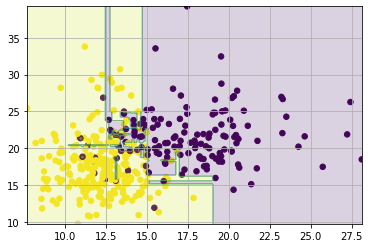

In [16]:
def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=200),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=200))
#     print(xx.shape,yy.shape)
#     print(X[:, 0].shape, X[:, 1].shape)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#     print(Z.shape)
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)

# plot_tree(bag, X_train[:,:2], y_train)    
    
    
    
########### only 2 featuresssssssss
bag = BaggingClassifier(tree, n_estimators=5, max_samples=0.99)
bag.fit(X_train[:,:2], y_train)
print(X_train[:,:2].shape)
plot_tree(bag, X_train[:,:2], y_train)